In [34]:
"""
Extracts word count from the messages using CountVectorizer. Outputs a csv file
with the most and least frequent word occurance throughout the documents.
"""
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import StemmerI, SnowballStemmer
from nltk.stem.porter import PorterStemmer

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
import plotly.express as px

from sqlalchemy import create_engine

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding

from spellchecker import SpellChecker 

import time


In [2]:

def load_data(database_filepath, n_sample=5000):
    """
    Import data from database into a DataFrame. Split DataFrame into
    features and predictors, `X` and `Y`. Additionally, extract the names
    of target categories.

    Preprocess data.

    Params:
    -------
        database_filepath: file path of database

    Returns:
    -------
        tuple(X, Y, category_names)
        pd.DataFrame of features and predictors, `X` and `Y`, respectively.
        List of target category names
    """

    engine = create_engine(f'sqlite:///{database_filepath}')

    # extract directory name
    dir_ = re.findall(".*/", database_filepath)

    # extract table name by stripping away directory name
    table_name = database_filepath.replace('.db', '').replace(dir_[0], "")
    df = pd.read_sql_table(f'{table_name}', engine)

    # Sample data
    if n_sample > 0:
        df = df.sample(n_sample)

    # reset index
    df.reset_index(drop=False, inplace=True)

    # DROP ROWS/COLUMN
    # where sum across entire row is less than 1
    null_idx = np.where(df.loc[:, 'related':].sum(axis=1) < 1)[0]
    # drop rows which contain all null values
    df.drop(null_idx, axis=0, inplace=True)

    # explore `related` feature where its labeled as a `2`
    related_twos = df[df['related'] == 2]
    df.drop(index=related_twos.index, inplace=True)

    # reset index
    df = df.reset_index(drop=True)

    # define features and predictors
    X = df.loc[:, 'message']
    Y = df.loc[:, 'related':]
    Y.drop(Y.nunique()[Y.nunique() < 2].index.tolist(), axis=1, inplace=True)

    # extract label names
    category_names = Y.columns.to_list()

    return X, Y, category_names

def spell_correct(word):
    return spell.correction(word)

def drop_short_words(text):
    return [word for word in text if len(word) >= 4]

def remove_url(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "")   
    return text

def tokenize(text):
    """
    Replace `url` with empty space "".
    Tokenize and lemmatize input `text`.
    Converts to lower case and strips whitespaces.

    Returns:
    --------
        dtype: list, containing processed words
    """
    # check and drop URL
    text = remove_url(text)
    
    # load stopwords
    stop_words = stopwords.words("english")
    # remove additional words
    remove_words = ['one', 'see', 'thank', 'thank you', 'thanks',
                    'you', 'http']
    stop_words = stop_words + remove_words

    # remove punctuations (retain alphabetical and numeric chars) and convert to all lower case
    # tokenize resulting text
    tokens = word_tokenize(re.sub(r"[^a-zA-Z]", ' ', text.lower().strip()))
  
    # drop words less than 3 chars long
    no_shorts = drop_short_words(tokens)
    
    # lemmatize and remove stop words
#     lemmatized = [lemm.lemmatize(word) for word in no_shorts if word not in stop_words]
    lemmatized = [stemmer.stem(word) for word in no_shorts if word not in stop_words]

    return lemmatized


In [64]:
spell = SpellChecker()
stemmer = PorterStemmer()

X, Y, category_names = load_data('../data/disaster_response.db', n_sample=0)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y.values,
                                                    test_size=0.75)
print('X-train shape:', X_train.shape)

In [70]:
# save text labels for scatter plot
np.save('../data/text_labels', X_train.values)

In [65]:
count_vec = TfidfVectorizer(
        tokenizer=tokenize,
        ngram_range=(1, 1),
#         dtype=np.uint16,
#         max_features=5000,
        max_df=0.99,
        min_df=5,
        )
start_time = time.perf_counter()
word_matrix = count_vec.fit_transform(X_train).toarray()
print('Fit transform time:', time.perf_counter() - start_time)

# extract words/features
num_features = len(count_vec.get_feature_names())
print('-'*75)
print('Number of features:', num_features)
features = count_vec.get_feature_names()

Fit transform time: 3.5136438999998063
---------------------------------------------------------------------------
Number of features: 2152


In [69]:
np.save??

Signature: np.save(file, arr, allow_pickle=True, fix_imports=True)
Source:   
@array_function_dispatch(_save_dispatcher)
def save(file, arr, allow_pickle=True, fix_imports=True):
    """
    Save an array to a binary file in NumPy ``.npy`` format.

    Parameters
    ----------
    file : file, str, or pathlib.Path
        File or filename to which the data is saved.  If file is a file-object,
        then the filename is unchanged.  If file is a string or Path, a ``.npy``
        extension will be appended to the file name if it does not already
        have one.
    arr : array_like
        Array data to be saved.
    allow_pickle : bool, optional
        Allow saving object arrays using Python pickles. Reasons for disallowing
        pickles include security (loading pickled data can execute arbitrary
        code) and portability (pickled objects may not be loadable on different
        Python installations, for example if the stored objects require libraries
        that are not a

### SpellChecker

In [3]:
from spellchecker import SpellChecker 
spell = SpellChecker()

In [51]:
# spell.candidates('watr')
spell.correction('windy')
# dir(spell.word_frequency)
spell.correction('our')

# find those words that may be misspelled
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

happening


In [69]:
spell.unknown(tokenize(msg[0]))

TypeError: float() argument must be a string or a number, not 'list'

In [6]:
import concurrent.futures
import threading


In [91]:
start_time = time.perf_counter()
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        executor.map(tokenize, X_train[:5].values)
end_time = time.perf_counter()
print(end_time - start_time)       

0.0055231999999705295


#### Test tokenizer

In [24]:
X_train.values[35:40]

array(['When the project ends early next year, deep tube wells will also have been built for seven communities, with the organisation also working with local people to promote hygiene.',
       'The Rangiya-Murkongselek section which was disrupted has been restored upto Lakhimpur.',
       'If I need a job in the NGOs or the government, what should I do? ',
       'UN Haiti headquarter collapses in earthquake n http tinyurl.com y9x5p5p',
       'Built by the Mata Amritanandamayi Math, the 340 houses will provide permanent shelter to the people of Samanthanpettai, five km from here, where the towering sea waves washed away 140 people Dec 26, 2004.'],
      dtype=object)

In [14]:
start_time = time.perf_counter()
msg = ['our homes have been distroyed by the floods and windi, all swept away. ab akl Can you please send help? http://github.com 12385', 
      'our homes have been distroyed by the floods and windi, all swept away. ab akl Can you please send help? http://github.com 12385']
new_toks = [tokenize(w) for w in msg]
print(new_toks)

spell_correct(word) for 
      
end_time = time.perf_counter()
print(end_time - start_time)


[['home', 'distroy', 'flood', 'windi', 'swept', 'away', 'pleas', 'send', 'help'], ['home', 'distroy', 'flood', 'windi', 'swept', 'away', 'pleas', 'send', 'help']]
0.0022377999999889653


## TSNE

Fit transform time: 36.728264400000626


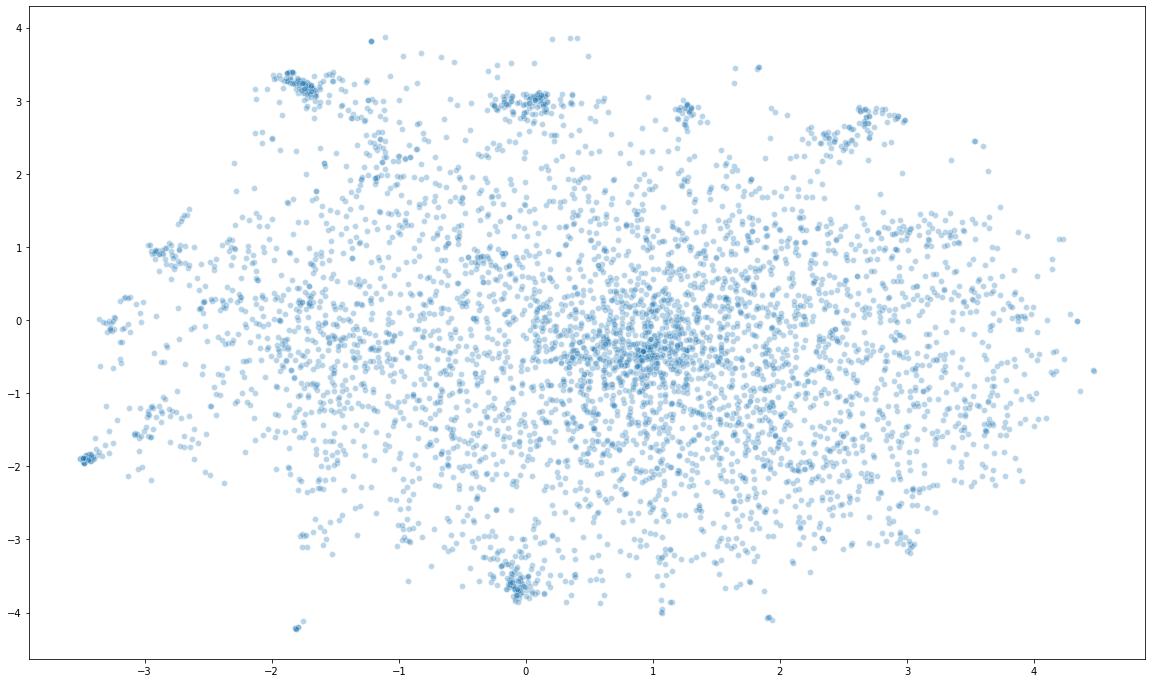

In [66]:
# TSNE 
tsne = TSNE(n_components=2,
            perplexity=75,
            init='pca',
            n_iter=1000,
            n_jobs=-1,
            random_state=11)

start_time = time.perf_counter()
X_tsne = tsne.fit_transform(word_matrix)
print('Fit transform time:', time.perf_counter() - start_time)

# save array to file
np.save('../data/X_tsne', X_tsne)

# scatter plot
plt.figure(figsize = (20,12))
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], alpha=0.3)
plt.show()

### K-Means
Try to group similar messages together with K-Means

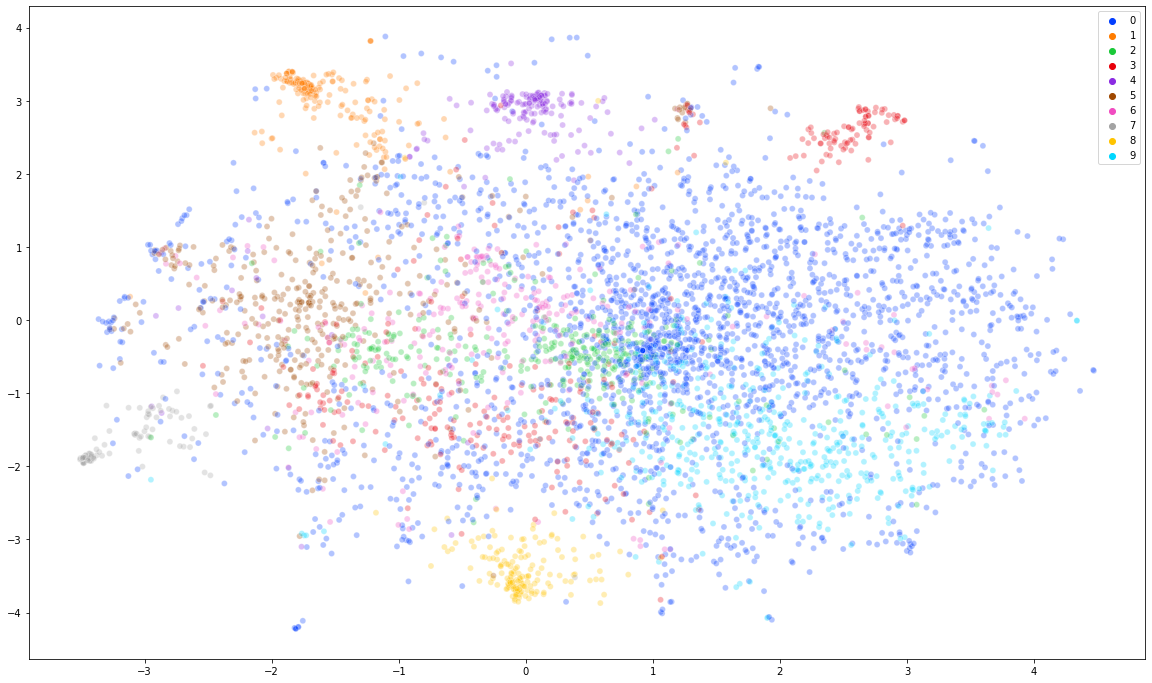

In [67]:
# k = y_train.shape[1]
k = 10
kmeans = KMeans(n_clusters=k, n_jobs=6, random_state=11)
y_pred = kmeans.fit_predict(word_matrix)

# save predicted clusters
np.save('../data/y_pred_clusters', y_pred)

# colors
palette = sns.color_palette("bright", len(set(y_pred)))
# scatter plot
plt.figure(figsize = (20,12))
sns.scatterplot(X_tsne[:, 0], X_tsne[:, 1], hue=y_pred, legend='full', palette=palette, alpha=0.3)
plt.show()

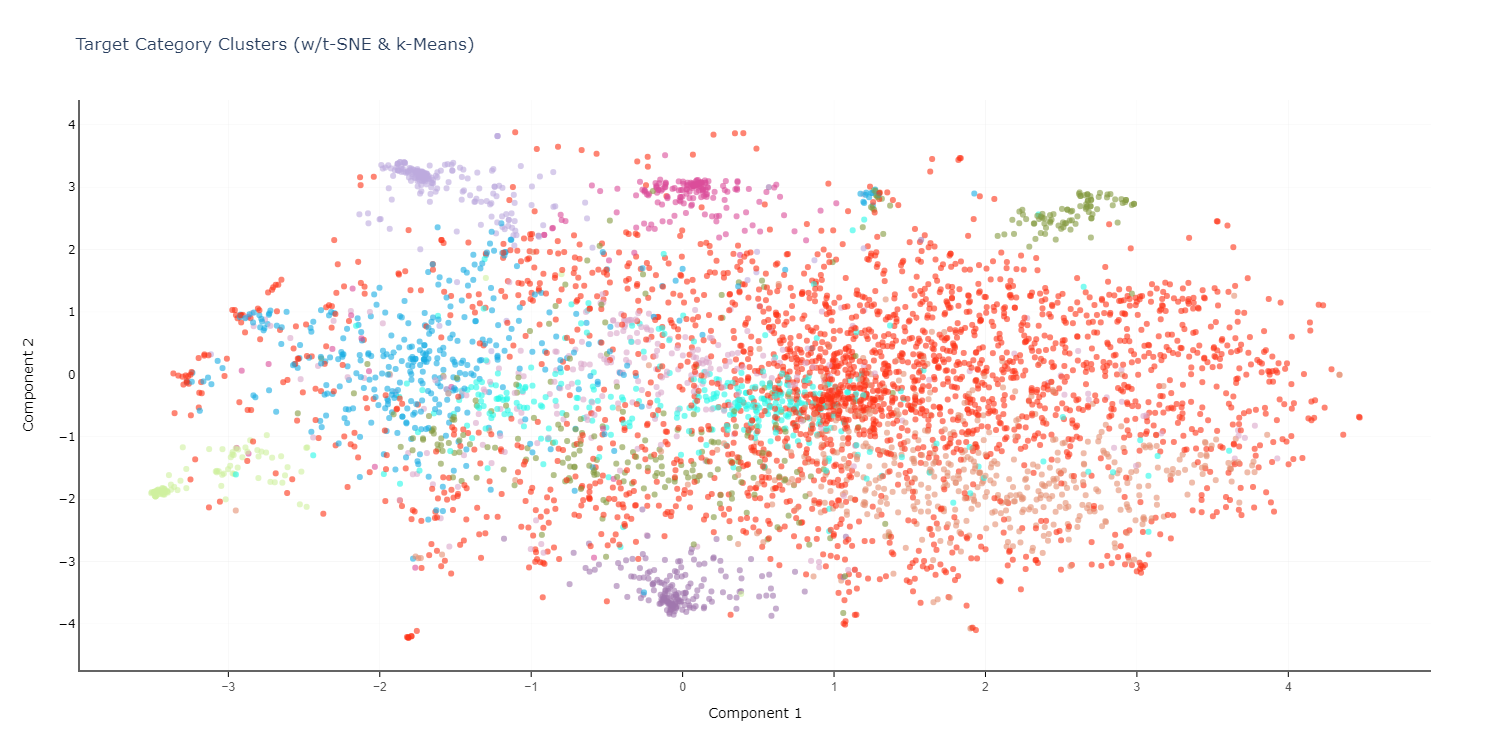

In [68]:
disc_colors = px.colors.qualitative.Light24

# define y-axis properties
y_axis = dict(
    gridcolor='rgb(225, 225, 225)',
    gridwidth=0.25,
    linecolor='rgb(100, 100, 100)',
    linewidth=2,
    showticklabels=True,
    color='black'
)
# update x-axis params
x_axis = y_axis.copy()
x_axis.update(dict(
    ticks='outside',
    tickfont=dict(
        family='Arial',
        color='rgb(82, 82, 82)',))
    )
# Scatter figure
fig = go.Figure([
    go.Scatter(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        mode='markers',
        marker_color=y_pred,
        marker=dict(size=6,
                    opacity=0.6,
                    colorscale=disc_colors),
        text=X_train.values,
    )])
# Edit layout
fig.update_layout(
    title='Target Category Clusters (w/t-SNE & k-Means)',
    height=750,
    plot_bgcolor='white',
    yaxis=y_axis,
    xaxis=x_axis,
#     showlegend=True,
    xaxis_title='Component 1',
    yaxis_title='Component 2',
)
fig.show()

## PCA

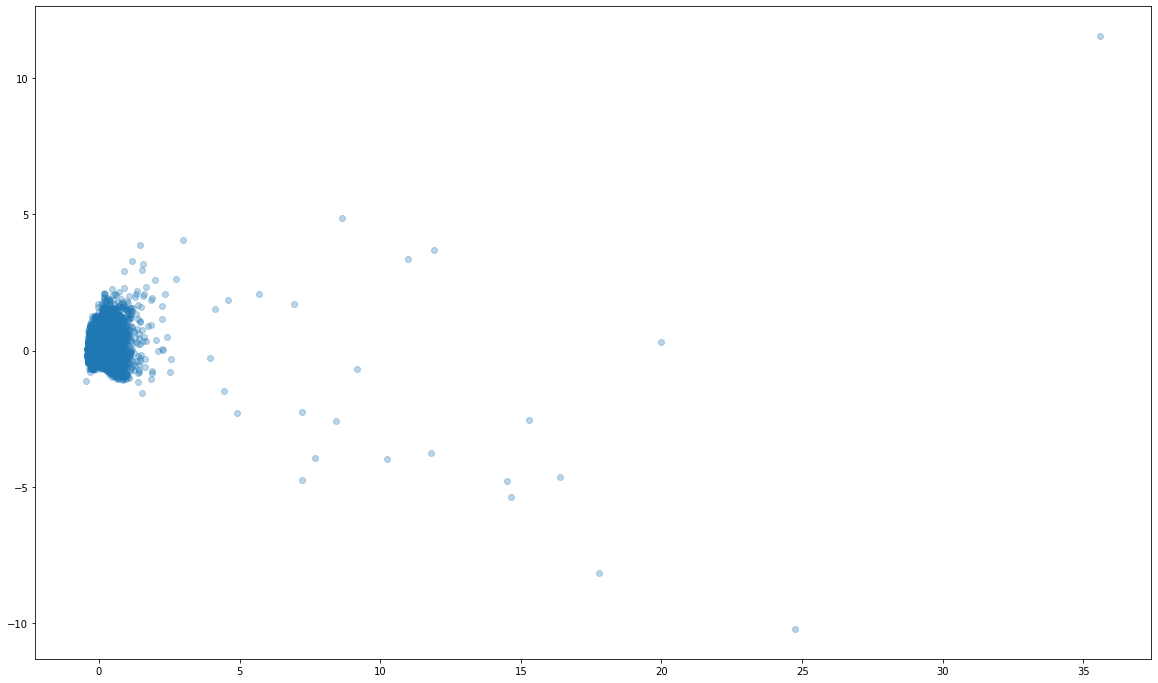

In [33]:
# PCA 
pca = PCA(n_components=2,
           random_state=11)

X_pca = pca.fit_transform(word_matrix)


fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(1,1,1) 
ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3)
# iterate over each word to label the points
# plt.figure(figsize=(16, 16))
# for i in range(X_pca.shape[0]):
    
#     ax.scatter(X_pca[i, 0], X_pca[i, 1], alpha=0.3)
#     ax.annotate(features[i],
#                  xy=(X_pca[i, 0], X_pca[i, 1]),
#                  xytext=(1, 1),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom'
#                 )

# plt.xlim(-0.5, 2)
# plt.ylim(-0.75, 0.5)
plt.show()

## NMF

In [34]:
# NMF 
nmf = NMF(n_components=2,
          l1_ratio=0.1,
          max_iter=100,
          random_state=11,
         )

X_nmf = nmf.fit_transform(word_matrix)

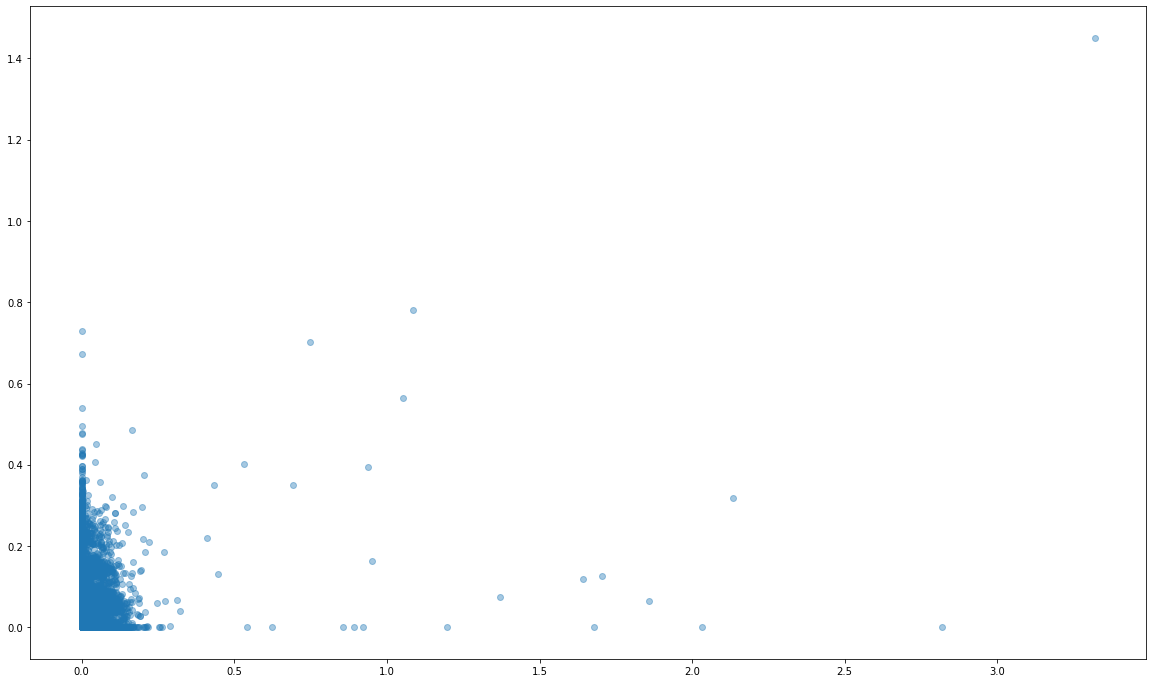

In [35]:
# iterate over each word to label the points
plt.figure(figsize=(20,12))
plt.scatter(X_nmf[:, 0], X_nmf[:, 1], alpha=0.4)

# for i in range(X_nmf.shape[0]):
#     plt.annotate(features[i],
#                  xy=(X_nmf[i, 0],b X_nmf[i, 1]),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')
    
# plt.xlim(0, 0.2)
# plt.ylim(0, 0.2)
plt.show()

## LLE (LocallyLinearEmbedding)

In [123]:
# LocallyLinearEmbedding??